In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
train_dir = '/kaggle/input/rsbdsl38/RSBDSL38_ver01/RSBDSL38_resized_splitted/train'
val_dir = '/kaggle/input/rsbdsl38/RSBDSL38_ver01/RSBDSL38_resized_splitted/val'
test_dir = '/kaggle/input/rsbdsl38/RSBDSL38_ver01/RSBDSL38_resized_splitted/test'
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7592 images belonging to 38 classes.
Found 1633 images belonging to 38 classes.
Found 1649 images belonging to 38 classes.


In [3]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the ResNet50 model pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(38, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 242s 751ms/step - accuracy: 0.0406 - loss: 3.6396 - val_accuracy: 0.1304 - val_loss: 3.4866 - learning_rate: 1.0000e-05
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 126s 517ms/step - accuracy: 0.1234 - loss: 3.4015 - val_accuracy: 0.4378 - val_loss: 2.6758 - learning_rate: 1.0000e-05
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 125s 513ms/step - accuracy: 0.3718 - loss: 2.6424 - val_accuracy: 0.6497 - val_loss: 1.5686 - learning_rate: 1.0000e-05
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.5639 - loss: 1.7513 - val_accuracy: 0.7563 - val_loss: 1.0001 - learning_rate: 1.0000e-05
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 180s 735ms/step - accuracy: 0.6827 - loss: 1.2147 - val_accuracy: 0.8279 - val_loss: 0.7157 - learning_rate: 1.0000e-05
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 125s 512ms/step - accuracy: 0.7488 - loss: 0.9082 - val_accuracy: 0.8549 - val_loss: 0.5605 - learning_rate: 1.0000e-05
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 125

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - accuracy: 0.9632 - loss: 0.1355
Test accuracy from evaluate: 96.66%
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step
Accuracy: 0.9666464523953912


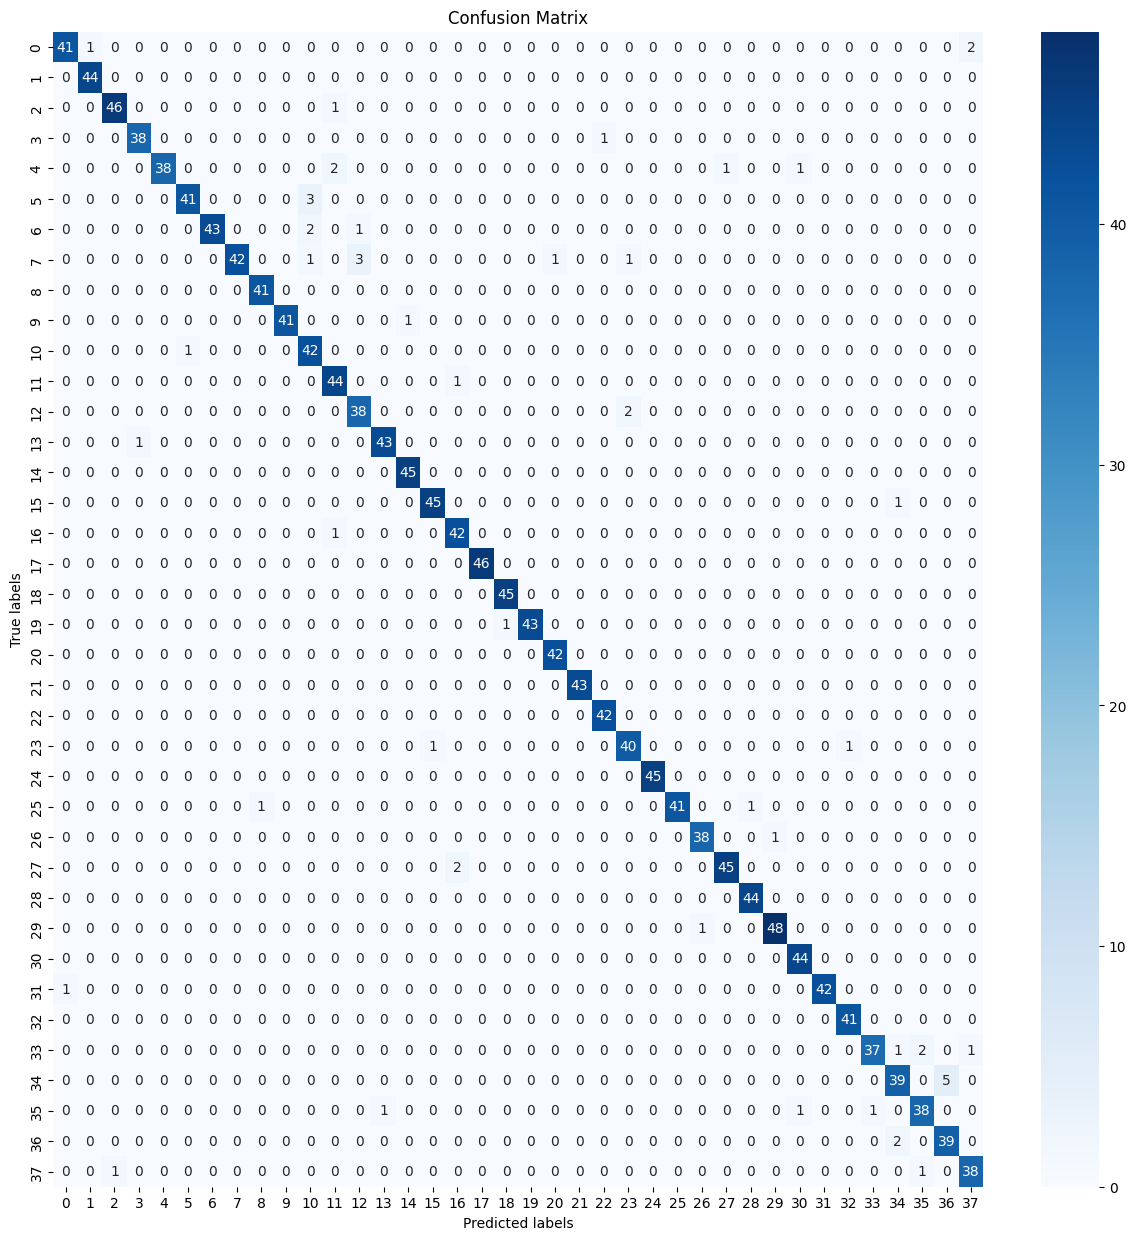

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.98      1.00      0.99        44
           2       0.98      0.98      0.98        47
           3       0.97      0.97      0.97        39
           4       1.00      0.90      0.95        42
           5       0.98      0.93      0.95        44
           6       1.00      0.93      0.97        46
           7       1.00      0.88      0.93        48
           8       0.98      1.00      0.99        41
           9       1.00      0.98      0.99        42
          10       0.88      0.98      0.92        43
          11       0.92      0.98      0.95        45
          12       0.90      0.95      0.93        40
          13       0.98      0.98      0.98        44
          14       0.98      1.00      0.99        45
          15       0.98      0.98      0.98        46
          16       0.93      0.98      0.95        43
    

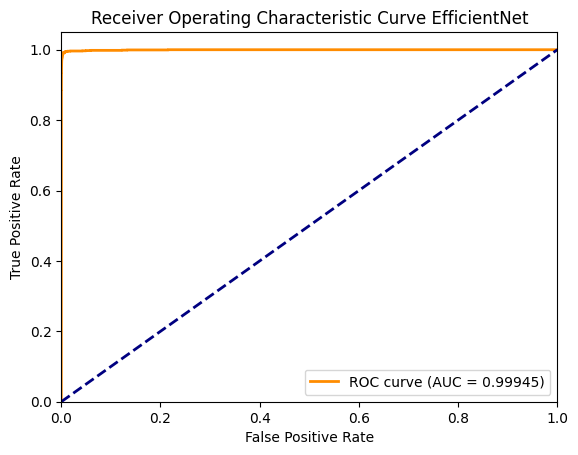

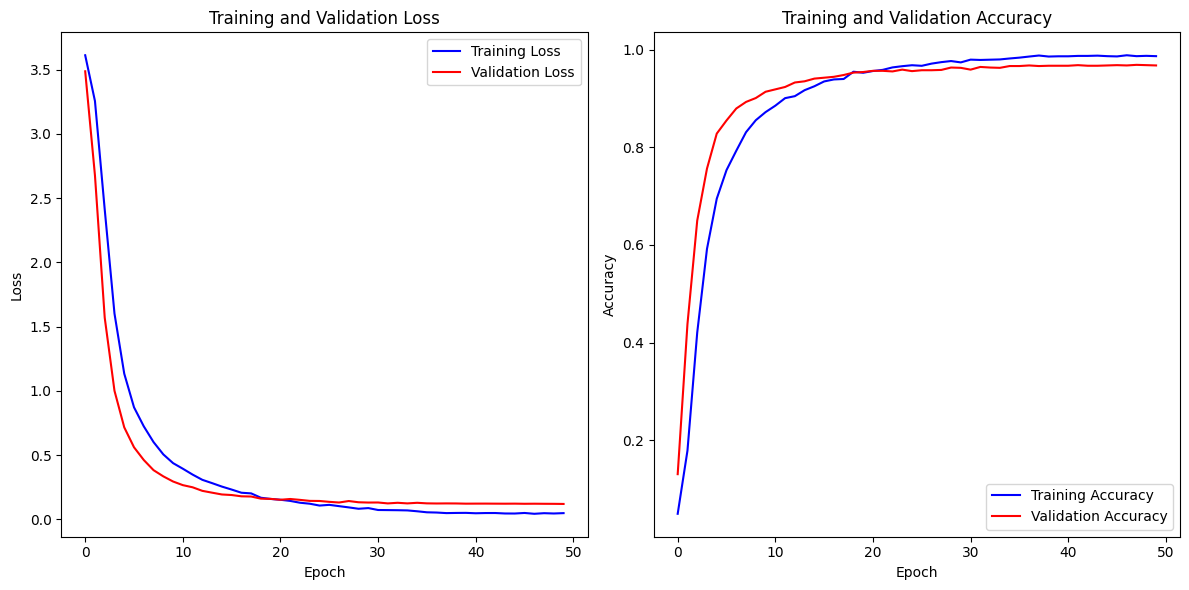

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score

# # Recheck Data Generators
# test_generator = test_datagen.flow_from_directory(
#     '/content/data',  # Make sure this directory is correct
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False  # Ensure no shuffling for consistency in predictions
# )

# 1. Evaluate model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy from evaluate: {test_acc * 100:.2f}%')


# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve EfficientNet')
plt.legend(loc="lower right")
plt.show()

# Plot loss and accuracy per epoch
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()